In [1]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from textwrap import wrap

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

# Load data 

In [19]:
pgroup = 'p22250'
Loaddir_name = ''

#runlist = np.arange(41, 45)
runlist = [157]
t0_offsets = [0]*len(runlist)

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [20]:
#Plot_correlations_scan(pgroup, Loaddir, runlist, timescan=True, lowlim = 0.99)
#Plot_scan_2diodes(pgroup, Loaddir, runlist, timescan=True)

Run 157, Delays_stage offset by 0 fs
Run 157, Delays_corr offset by 0 fs
[157]
1 scan(s), 122483 total on/off shots


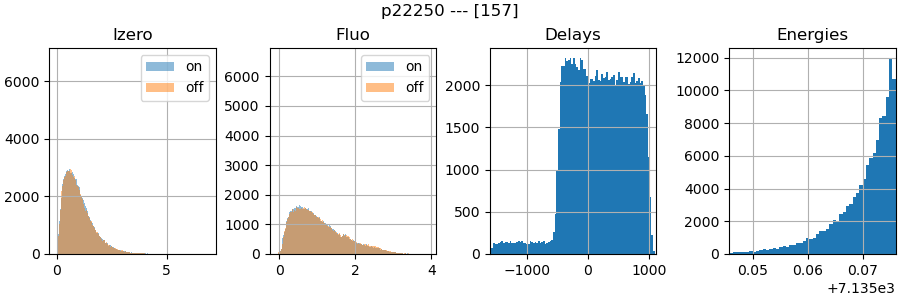

Time delay axis rebinned with TT data


In [21]:
average_twodiodes = False
withTT    = True

switch_diodes = False
##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
#firstrun = glob.glob('/sf/alvra/data/{}/res/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

acqlist = np.arange(1, len(scan.files))

data = {}
globals().update(data)

#data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, average_twodiodes=average_twodiodes)
#data, titlestring_stack = load_reduced_data_loop(pgroup, Loaddir, runlist, acqlist, average_twodiodes=average_twodiodes)
data, titlestring_stack = load_reduced_data_offset(pgroup, Loaddir, runlist, t0_offsets, average_twodiodes, switch_diodes)

globals().update(data)
print (runlist)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(pump_1)))

Plot_reduced_data(data, scan, titlestring_stack, withTT, timescan=True)

pump_1       = np.asarray(pump_1)
unpump_1     = np.asarray(unpump_1)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
energy       = np.asarray(energy)
Delays_corr  = np.asarray(Delays_corr)

## [Average scans](#Averaged-scans)
## [Overlay curves](#Overlay-data)

# Average scans

Time delay axis rebinned with TT data
32971 shots out of 91198 survived (total shots: 122483)


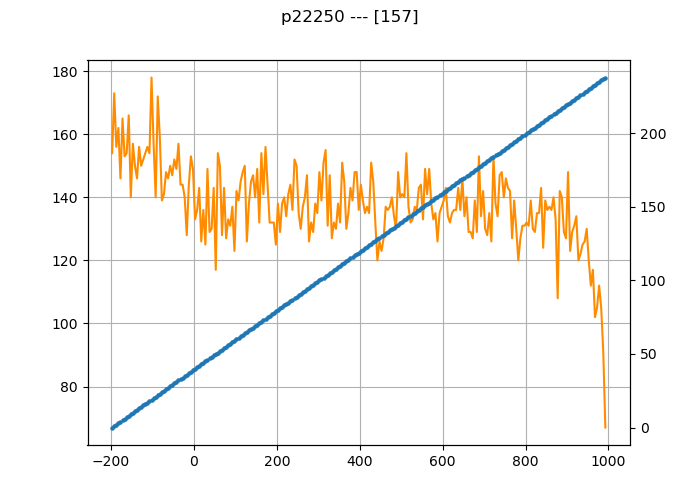

In [22]:
quantile = 0.6
binsize = 5
min_delay = -200
max_delay = 1000

(variable_bins, numbins)= (False, 100)
thresh=0
n_sigma=3

####################################################################
####################################################################

pp_TT, err_pp, Delay_fs_TT, howmany = \
Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma, numbins, variable_bins)

#pp_TT, GS, ES, err_pp, Delay_fs_TT, howmany = \
#Rebin_and_filter_timescans_noPair(data, binsize, min_delay, max_delay, quantile, withTT)

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, howmany, color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

#ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
#ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()


Width = 32.4028 fs
t0 = 4.4276 fs


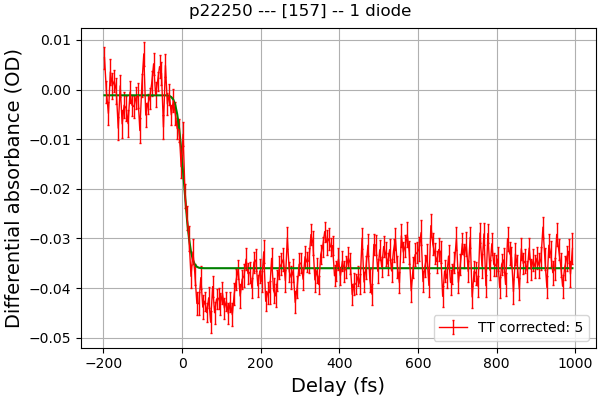

In [23]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,4))
plt.suptitle(titlestring_stack+' -- 1 diode')
if average_twodiodes:
   plt.suptitle(titlestring_stack+' -- 2diodes')

label = 'Rebinned: {} fs'.format(binsize)
if withTT:
    label = 'TT corrected: {}'.format(binsize)

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label=label)
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [0, 20, 0, 100, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    #t0_fs = popt[0]
    #width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))
plt.grid()
plt.ylabel('Differential absorbance (OD)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.show()

#plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_oscill.png', )

In [651]:
# import pandas as pd
# outFiles = '/das/work/p21/p21960/excel_v2/'  #Location to save excel files
# ifSave = False
# suffix = '' 

# Delay_fs_TT, pp_TT
# if ifSave:
#     df = pd.DataFrame(np.vstack((Delay_fs_TT,pp_TT)).T, columns = ['Delay','Difference'])
#     fn = 'times_'+'_'.join([str(x) for x in runlist])+suffix+'.cs7100 to 7150 eVv'
#     df.to_csv(outFiles+fn, index = False)

# Fit risetime

In [12]:
from lmfit.models import PseudoVoigtModel

pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)

mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=0.008, center= 0, sigma=1, fraction=0.5, x=Delay_fs_TT)

pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 20, 0])

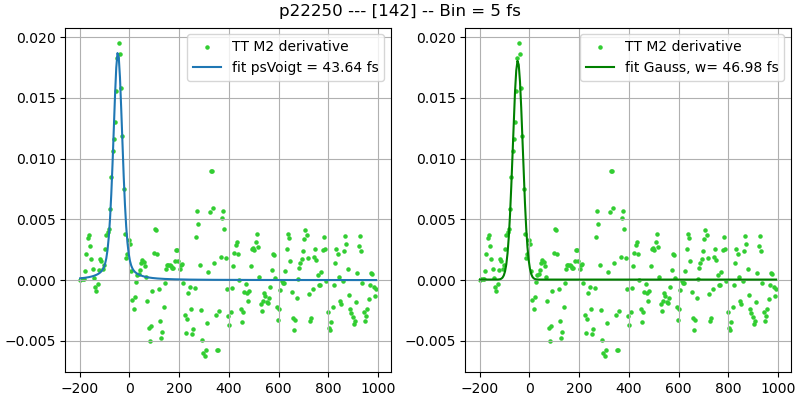

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
fig.suptitle(titlestring_stack + ' -- Bin = {} fs'.format(binsize))
ax1.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax1.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax1.grid()
ax1.legend(loc='upper right')

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax2.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax2.legend(loc='upper right')
ax2.grid()
plt.show()

# FFT

103
267
(164,) (164,)


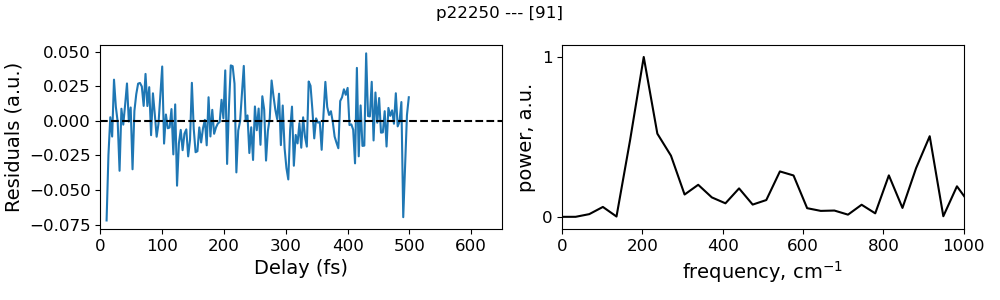

In [333]:
chosen_point_start = 10  #in fs
index_point_start = int(np.argwhere(Delay_fs_TT > chosen_point_start)[0])
print (index_point_start)

chosen_point_end = 500 #in fs
index_point_end = int(np.argwhere(Delay_fs_TT > chosen_point_end)[0])
print (index_point_end)

transient = pp_TT[index_point_start:index_point_end]
x = Delay_fs_TT[index_point_start:index_point_end]

fit = pp_fit[index_point_start:index_point_end]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-fit
            
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
plt.suptitle(titlestring_stack)
plt.subplot(121)

#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(chosen_point_start + np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Residuals (a.u.)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.xlim(0,650)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,2200)
plt.xlabel('frequency, cm$^{-1}$', fontsize=14)
plt.ylabel('power, a.u.', fontsize=14)
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
plt.xlim(0,1000)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()
# plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_fft.png', )

In [47]:
average_twodiodes = False
withTT    = True
switch_diodes = False

pgroup = 'p22251'
Loaddir_name = ''

runlist = [33]

jsonfile = get_json_from_run(runlist, pgroup)
scan = SFScanInfo(jsonfile[0])
acqlist = np.arange(1, len(scan.files))

#badrun = [113, 114]
#acqlist = np.setdiff1d(acqlist,badrun)

chunksize = 1 #len(acqlist)

quantile = 0.7

binsize = 5
min_delay = -200
max_delay = 500

(variable_bins, numbins)= (False, 100)
thresh=0
####################################################
from lmfit.models import PseudoVoigtModel
acqchunks = np.resize(acqlist, (len(acqlist)//chunksize,chunksize))

Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
t0_fit = []
#w = []
t0_der = []
#w_der = []
t0_voigt = []
#w_voigt = []

for chunk in acqchunks:
    clear_output(wait=True)
    data = {}
    globals().update(data)
    
    data, titlestring_stack = load_reduced_data_loop(pgroup, Loaddir, runlist, chunk)
    globals().update(data)
    print ('Run {}, acq {}, {} total on/off shots'.format(runlist, chunk, len(pump_1)))

    pump_1       = np.asarray(pump_1)
    unpump_1     = np.asarray(unpump_1)
    Izero_pump   = np.asarray(Izero_pump)
    Izero_unpump = np.asarray(Izero_unpump)
    Delays_stage = np.asarray(Delays_stage)
    arrTimes     = np.asarray(arrTimes)
    energy       = np.asarray(energy)
    Delays_corr  = np.asarray(Delays_corr)
    
    pp_TT, err_pp, Delay_fs_TT, howmany = \
    Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, thresh, withTT, numbins, variable_bins)
    
    fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    # Fit the curve with function chosen before
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4, 1)# overwrite some values (index) if needed
    fit.p0 = better_p0(fit.p0, 0, 0)# overwrite some values (index) if needed
    
    fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fit.append(fit.popt[0])
    #w.append(np.abs(fit.popt[2]))
    
    pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 20, 0])
    t0_der.append(parameters_M2[0])
    #w_der.append(np.abs(parameters_M2[2]*2.355))

    ## Pseudo Voigt fit of the derivative
    mod = PseudoVoigtModel()
    pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
    init = mod.eval(pars, x=Delay_fs_TT)
    out = mod.fit(pp_TT_derivative, amplitude=0.0015, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

    t0_voigt.append(out.params.get('center').value)
    #w_voigt.append(out.params.get('fwhm').value)
print ('----------------------------------')
#print ('Fit:  {} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_fit, decimals=2),np.nanmean(t0_fit), np.nanstd(t0_fit), binsize))
#print ('Gauss:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_der, decimals=2),np.nanmean(t0_der), np.nanstd(t0_der), binsize))
#print ('Voigt:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_voigt, decimals=2),np.nanmean(t0_voigt), np.nanstd(t0_voigt), binsize))
print ('Fit: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_fit), np.nanstd(t0_fit), binsize))
print ('Gauss: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_der), np.nanstd(t0_der), binsize))
print ('Voigt: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_voigt), np.nanstd(t0_voigt), binsize))

['/sf/alvra/data/p22251/work/Reduced_data/run0033-MbCO_timescan_7122eV_cont/acq0024/run_array.npy']
Run [33], acq [24], 4888 total on/off shots
Time delay axis rebinned with TT data
1120 shots out of 3041 survived (total shots: 4888)
----------------------------------
Fit: -6.04 fs +/- 22.83, binsize 5 fs
Gauss: -1.96 fs +/- 17.24, binsize 5 fs
Voigt: -15.53 fs +/- 103.46, binsize 5 fs


Width = 248.4183 fs
t0 = -2.7313 fs


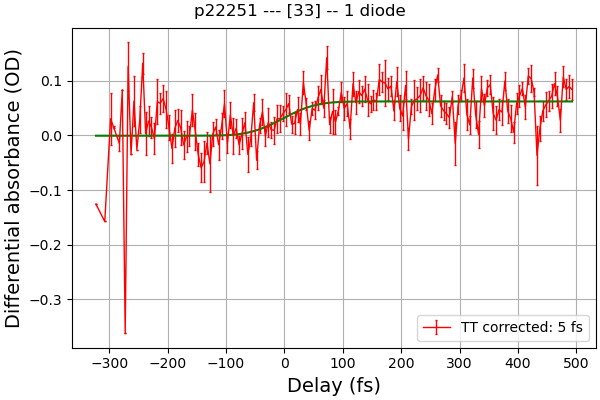

In [43]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,4))
plt.suptitle(titlestring_stack+' -- 1 diode')
if average_twodiodes:
   plt.suptitle(titlestring_stack+' -- 2diodes')

label = 'Rebinned: {} fs'.format(binsize)
if withTT:
    label = 'TT corrected: {} fs'.format(binsize)

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label=label)
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [0, 100, 0, 200, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    #t0_fs = popt[0]
    #width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs*2.355)))
    print("t0 = {:.4f} fs".format(t0_fs))
plt.grid()
plt.ylabel('Differential absorbance (OD)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.show()

#plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_oscill.png', )

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle('run {}'.format(runlist) + ' -- Chunksize={} -- Bin={} fs'.format(chuncksize, binsize))

ax1.plot(t0_fit, label='Fit')
ax1.plot(t0_der, label='Gauss der')
ax1.plot(t0_voigt, label='Voigt')
ax1.set_ylabel('width (fs)')
ax1.set_xlabel('chunk number')
ax1.legend(loc='best')
ax1.set_ylim(-100,100)
ax1.grid()
ax2.hist(t0_der, bins=100)
ax2.hist(t0_voigt, bins=100)
#ax2.set_xlim(0,1000)
ax2.grid()

# Fit decay constants

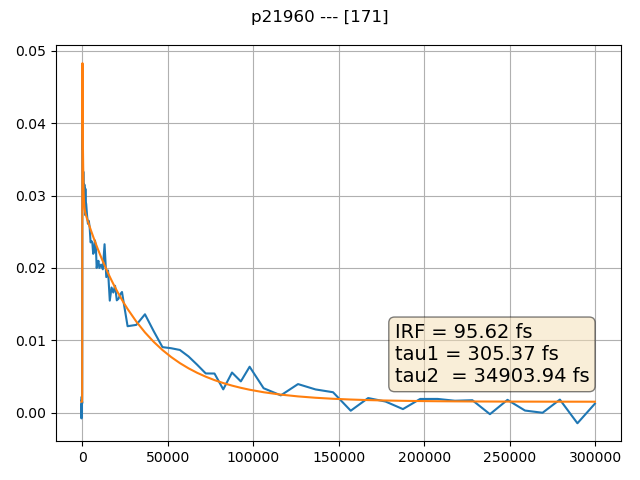

In [38]:
###################### 1 exp #################################
###   x0, sigma, amp1, tau1, C
p0 = [0,  100,   1,    1000, 1]
popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_1exp(Delay_fs_TT, *popt)

###################### 2 exp #################################
###   x0, sigma, amp1, tau1, C, amp2, tau2
p0 = [0,  200,   1,    1000, 1, 1,    10000]
popt,_  = curve_fit(model_decay_2exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(Delay_fs_TT, *popt)

###############################################################
fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, y_fit)

popt = np.pad(popt, (0, 7-len(popt)), 'constant', constant_values=np.nan)
boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.6, 0.15, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.grid()
plt.tight_layout()
#plt.ylim(-0.25, 2)
plt.show()

#os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/{}.png'.format(ROI.split(':')[-1]))

In [40]:
def Rebin_and_filter_timescans(data, binsize, minvalue, maxvalue, quantile, t0_mm, withTT=True, numbins=None, varbin_t=False):

    for k,v in data.items():
        data[k] = v
    
    pump_1 = np.asarray(data['pump_1'])
    unpump_1 = np.asarray(data['unpump_1'])
    Izero_pump = np.asarray(data['Izero_pump'])
    Izero_unpump = np.asarray(data['Izero_unpump'])
    Delays_stage = np.asarray(data['Delays_stage'])
    Delays_corr = np.asarray(data['Delays_corr'])

    if withTT:
        Delays = Delays_corr
    else:
        Delays = mm2fs(Delays_stage, t0_mm)

    binList = np.arange(minvalue, maxvalue, binsize)
    if varbin_t:
        binList = histedges_equalN(Delays, numbins)

    bin_centres = (binList[:-1] + binList[1:])/2
    delay_rebin = np.arange(minvalue + binsize/2, maxvalue - binsize/2, binsize)
    if varbin_t:
        delay_rebin = bin_centres

    pp_rebin = np.zeros(len(bin_centres))
    err_pp = np.zeros(len(bin_centres))

    totalshots = len(pump_1)
    howmany_before = []
    howmany = []

    for i in range(len(bin_centres)):
        cond1 = Delays >= binList[i]
        cond2 = Delays < binList[i+1]
    
        idx = np.where(cond1*cond2)[0]
        delay_rebin[i] = np.average(Delays[idx])
    
        pump    = pump_1[idx]
        unpump  = unpump_1[idx]
        Izero_p = Izero_pump[idx]
        Izero_u = Izero_unpump[idx]
        
        howmany_before.append(len(Delays[idx]))
    
        pump_filter, unpump_filter, Izero_pump_filter, Izero_unpump_filter = \
        correlation_filter(pump, unpump, Izero_p, Izero_u, quantile)
        
        howmany.append(len(pump_filter))

        pump_filter = pump_filter / Izero_pump_filter
        unpump_filter = unpump_filter / Izero_unpump_filter
    
        Pump_probe_shot = np.log10(pump_filter/unpump_filter)
    
        pp_rebin[i]  = np.nanmean(Pump_probe_shot)
        err_pp[i] = np.nanstd(Pump_probe_shot)/np.sqrt(len(Pump_probe_shot))
    if withTT:
        print('Time delay axis rebinned with TT data')
    else:
        print('Time delay axis rebinned with delay stage data')

    print ('{} shots out of {} survived (total shots: {})'.format(np.sum(howmany), np.sum(howmany_before), totalshots))
    return pp_rebin, err_pp, delay_rebin, howmany

## Overlay data

In [499]:
pgroup = 'p22250'

#unlist = np.arange(104, 117)

runlist = [88,90, 103,116,140]
Loaddir_folder = ''

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 5 runs: [88, 90, 103, 116, 140] from /sf/alvra/data/p22250/work/Reduced_data//


['/sf/alvra/data/p22250/work/Reduced_data/run0088-Timescan_7123eV_1p52uJ/run_array.npy',
 '/sf/alvra/data/p22250/work/Reduced_data/run0090-Timescan_7135eV_1p52uJ/run_array.npy',
 '/sf/alvra/data/p22250/work/Reduced_data/run0103-Timescan_7111p5eV_1p52uJ/run_array.npy',
 '/sf/alvra/data/p22250/work/Reduced_data/run0116-Timescan_7110p8eV_1p52uJ/run_array.npy',
 '/sf/alvra/data/p22250/work/Reduced_data/run0140-Timescan_7107p2eV_1p52uJ/run_array.npy']

Time delay axis rebinned with TT data
28539 shots out of 65246 survived (total shots: 122424)
Time delay axis rebinned with TT data
34166 shots out of 78670 survived (total shots: 146990)
Time delay axis rebinned with TT data
55288 shots out of 112238 survived (total shots: 146722)
Time delay axis rebinned with TT data
47208 shots out of 94562 survived (total shots: 122508)
Time delay axis rebinned with TT data
16232 shots out of 32298 survived (total shots: 69432)


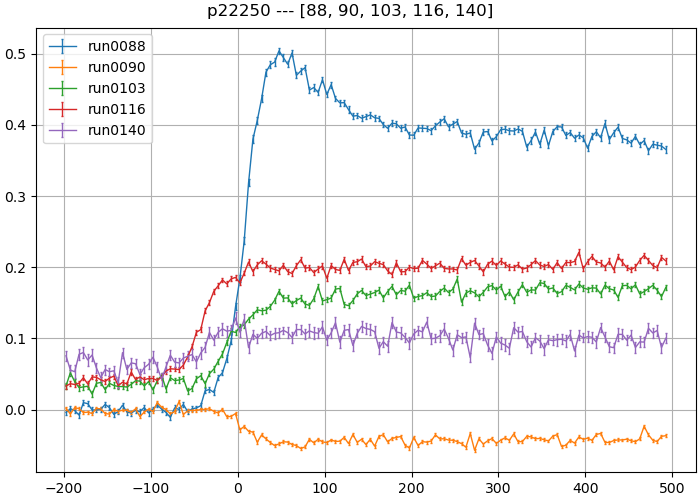

In [500]:
quantile = 0.7
twodiodes = True

withTT = True

binsize = 5
min_delay = -200
max_delay = 500

variable_bins=False
numbins=100

####################################################

fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    runname = 'run{:04d}'.format(run)
    data = {}
    data, _ = load_reduced_data(pgroup, Loaddir, [run], twodiodes)
    globals().update(data)
    
    pp_TT, err_pp, Delay_fs_TT,_ = \
    Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT)#numbins, variable_bins)
    
    ax1.errorbar(Delay_fs_TT, pp_TT, err_pp, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))
ax1.legend()
ax1.grid()


## save the averaged spectra to load them overlaid

In [104]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Reduced_data/Timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

run_array = {}
run_array[run_name.split('-')[0]] = {"name": run_name,
                                    "Pump_probe_Diode1": pp_TT, 
                                    "errbars_pp": err_pp,
                                    "Delay_fs": Delay_fs_TT
                                    }
np.save(reducedir+run_name+'/run_array', run_array)

In [ ]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_1diode(reducedir, run_name, scan, 
                         average_array(DataDiode1_pump, 0), 
                         average_array(DataDiode1_unpump, 0), 
                         average_array(Pump_probe_Diode1, 0), 
                         average_array(goodshots1, 0),
                         average_array(correlation1, 0))
print (reducedir+run_name)

## save the averaged spectra to load them overlaid

In [7]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_2diodes(reducedir, run_name, scan, 
                          average_array(DataDiode1_pump, 0), 
                          average_array(DataDiode1_unpump, 0), 
                          average_array(Pump_probe_Diode1, 0), 
                          average_array(goodshots1, 0), 
                          average_array(correlation1, 0),
                          average_array(DataDiode2_pump, 0), 
                          average_array(DataDiode2_unpump, 0), 
                          average_array(Pump_probe_Diode2, 0), 
                          average_array(goodshots2, 0),
                          average_array(correlation2, 0))
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001
